In [1]:
import pandas as pd
pd.set_option('display.max_columns', 300)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from uszipcode import SearchEngine


In [187]:
df=pd.read_csv('kc_house_data_train.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 0 to 17289
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17290 non-null  int64  
 1   date           17290 non-null  object 
 2   price          17290 non-null  float64
 3   bedrooms       17290 non-null  int64  
 4   bathrooms      17290 non-null  float64
 5   sqft_living    17290 non-null  int64  
 6   sqft_lot       17290 non-null  int64  
 7   floors         17290 non-null  float64
 8   waterfront     17290 non-null  int64  
 9   view           17290 non-null  int64  
 10  condition      17290 non-null  int64  
 11  grade          17290 non-null  int64  
 12  sqft_above     17290 non-null  int64  
 13  sqft_basement  17290 non-null  int64  
 14  yr_built       17290 non-null  int64  
 15  yr_renovated   17290 non-null  int64  
 16  zipcode        17290 non-null  int64  
 17  lat            17290 non-null  float64
 18  long  

In [3]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.729000e+04,1.729000e+04,17290.000000,17290.000000,17290.000000,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,4.565502e+09,5.407395e+05,3.372470,2.111943,2081.464604,1.524340e+04,1.490312,0.007981,0.238519,3.408502,7.654425,1789.306015,292.158589,1970.792019,83.806304,98078.193175,47.560058,-122.214258,1987.986698,12873.475824
std,2.874656e+09,3.733190e+05,0.939346,0.770476,920.018539,4.230462e+04,0.538909,0.088985,0.775229,0.651296,1.174718,829.265107,443.151874,29.343516,400.329376,53.607949,0.138412,0.140857,684.802635,27227.437583
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000
25%,2.114701e+09,3.210000e+05,3.000000,1.500000,1430.000000,5.081250e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471200,-122.329000,1490.000000,5111.250000
50%,3.903650e+09,4.500000e+05,3.000000,2.250000,1920.000000,7.642000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1974.000000,0.000000,98065.000000,47.571600,-122.230000,1840.000000,7622.500000
75%,7.301150e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.072575e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2214.500000,560.000000,1996.000000,0.000000,98118.000000,47.677900,-122.126000,2360.000000,10101.750000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,858132.000000


In [188]:
search = SearchEngine(simple_zipcode=True)
main_city = [search.by_zipcode(i).major_city for i in df['zipcode']]
df['main_city'] = main_city

In [165]:
cities=pd.get_dummies(df['main_city'], drop_first=True)
df=pd.concat([df,cities], axis=1)

In [166]:
df.columns=[col.replace(' ','_') for col in df.columns]


In [167]:
df['year']=df['date'].apply(lambda x: int(x[0:4]))
df['month']=df['date'].apply(lambda x: int(x[4:6]))


In [168]:
def make_dummies(df,col_dummies):
    new_df=df.copy()
    for col in col_dummies:
        dummies=pd.get_dummies(new_df[col], prefix='{}_'.format(col),drop_first=True)
        new_df=pd.concat([new_df,dummies], axis=1)
    return new_df

In [169]:
new_df=make_dummies(df,['year','month','view','condition','grade'])

In [170]:
extreme_cols=['bedrooms','bathrooms','sqft_living','sqft_lot','sqft_above','sqft_basement']

In [47]:
def ext_values(df, extreme_cols):
    new_df = df.copy()
    for col in extreme_cols:
        std = new_df[col].std()
        mean = new_df[col].mean()
        pos_value = mean+(5*std)
        neg_value = mean-(5*std)
        new_df[col] = new_df[col].apply(lambda x: pos_value if (x > pos_value) else (neg_value if x < neg_value else x))
    return new_df
#df=ext_values(df, extreme_cols)

In [171]:
new_df=ext_values(new_df, extreme_cols)

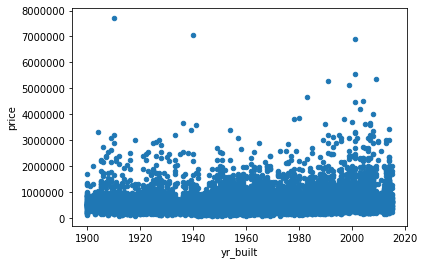

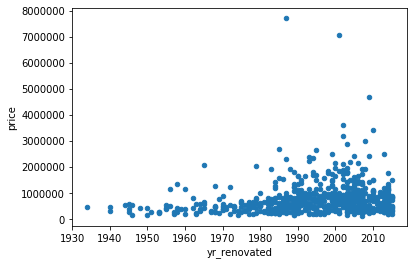

In [45]:
df.plot(kind='scatter',x='yr_built',y='price')
df[df['yr_renovated']>0].plot(kind='scatter',x='yr_renovated',y='price')

## Add Interactions

In [172]:
inter_df=new_df.drop(['date','id','main_city','year','month','view','condition','grade'], axis=1)
# poly_inter= PolynomialFeatures(interaction_only=True, include_bias=False)
# poly_inter.fit_transform(inter_df)

In [55]:
inter_df.shape

(17290, 251)

In [23]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_4,price_log,price_sqrt
count,1.729000e+04,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,4.565502e+09,5.407395e+05,4.535885,2.245283,2153.033651,13753.075256,1.490312,0.007981,0.238519,3.408502,7.654425,1851.994871,291.767131,1970.792019,83.806304,98078.193175,47.560058,-122.214258,1987.986698,12873.475824,26.334542,13.048109,706.468787
std,2.874656e+09,3.733190e+05,2.183236,1.080327,1107.595229,25527.976372,0.538909,0.088985,0.775229,0.651296,1.174718,999.988155,439.903216,29.343516,400.329376,53.607949,0.138412,0.140857,684.802635,27227.437583,3.600198,0.526865,204.068149
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,572.000000,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000,16.548755,11.225243,273.861279
25%,2.114701e+09,3.210000e+05,3.000000,1.500000,1430.000000,5081.250000,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471200,-122.329000,1490.000000,5111.250000,23.802702,12.679196,566.568619
50%,3.903650e+09,4.500000e+05,3.000000,2.250000,1920.000000,7642.000000,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1974.000000,0.000000,98065.000000,47.571600,-122.230000,1840.000000,7622.500000,25.900201,13.017003,670.820393
75%,7.301150e+09,6.450000e+05,7.129852,2.500000,2550.000000,10725.750000,2.000000,0.000000,0.000000,4.000000,8.000000,2214.500000,560.000000,1996.000000,0.000000,98118.000000,47.677900,-122.126000,2360.000000,10101.750000,28.339353,13.377006,803.118920
max,9.900000e+09,7.700000e+06,7.129852,5.193849,5761.538761,184461.895037,3.500000,1.000000,4.000000,5.000000,13.000000,5106.366443,2064.766087,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,858132.000000,52.677200,15.856731,2774.887385


In [151]:
corr=df.corr()

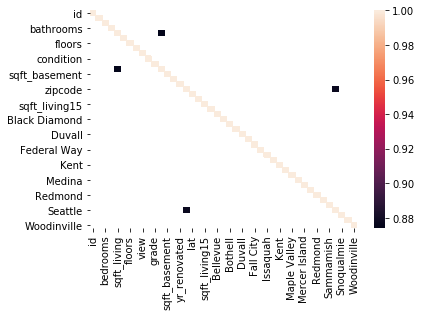

In [152]:
sns.heatmap(corr[corr>0.8])

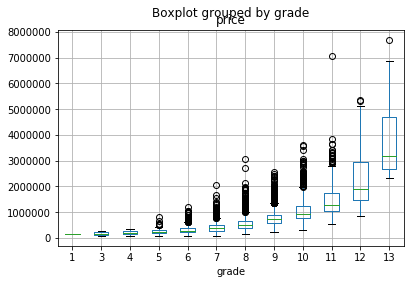

In [42]:
df.boxplot('price', by='grade')
# df['grade2']=np.sqrt(df['grade'])


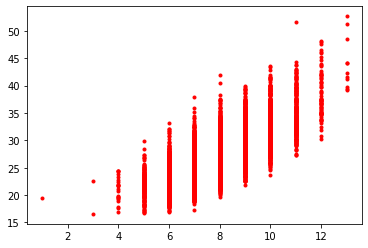

In [55]:
x=df['grade']
y=df['price']
plt.plot( x, y**0.25, 'r.')
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                price_4   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                 1.791e+04
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        09:30:07   Log-Likelihood:                -40536.
No. Observations:               17290   AIC:                         8.108e+04
Df Residuals:                   17288   BIC:                         8.109e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.6014      0.127     75.896      0.000       9.353       9.849
grade          2.1861      0.016    133.818      0.000       2.154       2.218
==============================================================================
Omnibus:                     1221.561   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1826.517
Skew:                           0.582   Prob(JB):                         0.00
Kurtosis:                       4.087   Cond. No.                         51.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

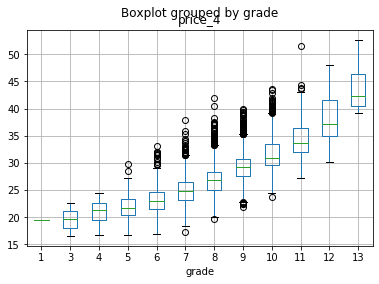

In [3]:

df.boxplot('price_4',by='grade')
ols(formula='price_4~grade',data=df).fit().summary()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E469903E48>]],
      dtype=object)

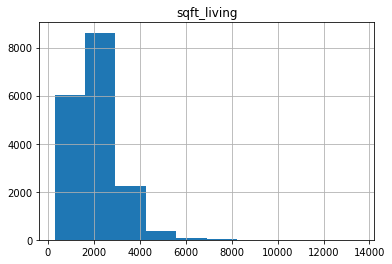

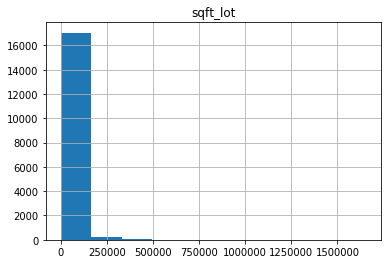

In [14]:
df.hist('sqft_living')
df.hist('sqft_lot')

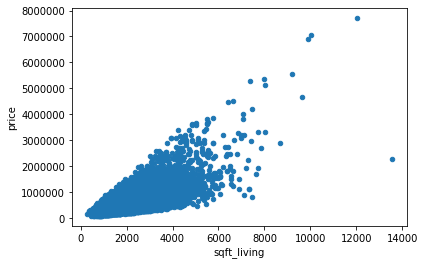

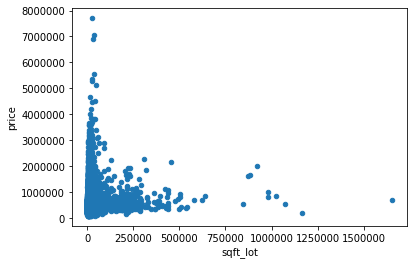

In [19]:
df.plot(kind='scatter',y='price',x='sqft_living')
df.plot(kind='scatter',y='price',x='sqft_lot')

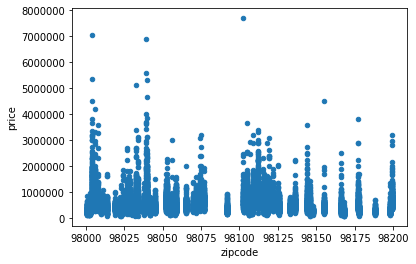

In [22]:
df.plot(kind='scatter',y='price', x='zipcode')

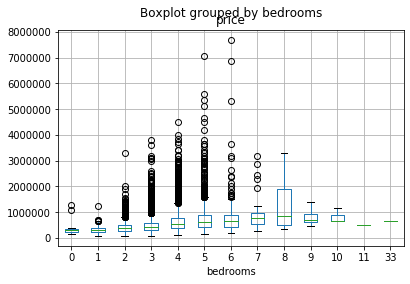

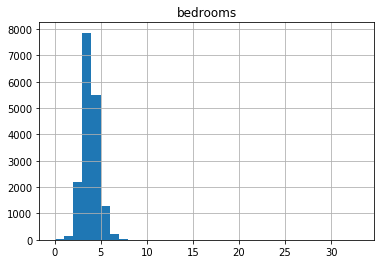

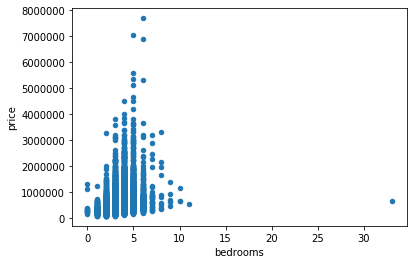

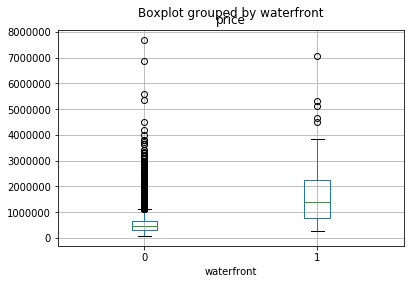

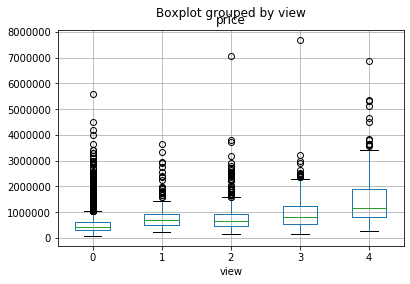

In [72]:
df.boxplot('price', by='bedrooms')
df.hist('bedrooms',bins=33)
df.plot(kind='scatter',x='bedrooms',y='price')
df.boxplot('price',by='waterfront')
df.boxplot('price', by='view')

In [71]:
ols(formula='price~sqft_living+sqft_lot+bedrooms+waterfront',data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     5205.
Date:                Thu, 30 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:06:45   Log-Likelihood:            -2.3953e+05
No. Observations:               17290   AIC:                         4.791e+05
Df Residuals:                   17285   BIC:                         4.791e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      6.6e+04   7158.128      9.220      0.000     5.2e+04       8e+04
sqft_living   308.8209      2.599    118.803      0.000     303.726     313.916
sqft_lot       -0.3476      0.046     -7.556      0.000      -0.438      -0.257
bedrooms    -5.017e+04   2496.574    -20.094      0.000   -5.51e+04   -4.53e+04
waterfront   8.046e+05   2.17e+04     37.068      0.000    7.62e+05    8.47e+05
==============================================================================
Omnibus:                    11007.565   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           384843.992
Skew:                           2.534   Prob(JB):                         0.00
Kurtosis:                      25.550   Cond. No.                     5.11e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
ols(formula='price_4~sqft_living+sqft_lot+bedrooms+waterfront+grade',data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                price_4   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     5063.
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        09:50:46   Log-Likelihood:                -38883.
No. Observations:               17290   AIC:                         7.778e+04
Df Residuals:                   17284   BIC:                         7.782e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      14.1205      0.153     92.221      0.000      13.820      14.421
sqft_living     0.0017   3.43e-05     48.317      0.000       0.002       0.002
sqft_lot    -1.459e-06    4.2e-07     -3.474      0.001   -2.28e-06   -6.36e-07
bedrooms       -0.1478      0.023     -6.412      0.000      -0.193      -0.103
waterfront      5.0146      0.198     25.329      0.000       4.627       5.403
grade           1.2072      0.023     51.912      0.000       1.162       1.253
==============================================================================
Omnibus:                      351.570   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              377.394
Skew:                           0.341   Prob(JB):                     1.12e-82
Kurtosis:                       3.244   Cond. No.                     5.11e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Create target and features

In [173]:
target=inter_df['price']
features=inter_df.drop(['price'], axis=1)

In [186]:
features.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'Bellevue',
       'Black_Diamond', 'Bothell', 'Carnation', 'Duvall', 'Enumclaw',
       'Fall_City', 'Federal_Way', 'Issaquah', 'Kenmore', 'Kent', 'Kirkland',
       'Maple_Valley', 'Medina', 'Mercer_Island', 'North_Bend', 'Redmond',
       'Renton', 'Sammamish', 'Seattle', 'Snoqualmie', 'Vashon', 'Woodinville',
       'year__2015', 'month__2', 'month__3', 'month__4', 'month__5',
       'month__6', 'month__7', 'month__8', 'month__9', 'month__10',
       'month__11', 'month__12', 'view__1', 'view__2', 'view__3', 'view__4',
       'condition__2', 'condition__3', 'condition__4', 'condition__5',
       'grade__3', 'grade__4', 'grade__5', 'grade__6', 'grade__7', 'grade__8',
       'grade__9', 'grade__10', 'grade__11', 'grade__12', 'grade__13'],
      dtype='object')

In [177]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=22,test_size=0.2)

In [144]:
poly_inter= PolynomialFeatures(interaction_only=True, include_bias=False)
inter=poly_inter.fit_transform(X_train)
inter_test= poly_inter.transform(X_test)

inter_cols=poly_inter.get_feature_names(X_train.columns)
inter_cols=[col.replace(' ','X') for col in inter_cols]

X_train_inter=pd.DataFrame(data=inter,columns=inter_cols)
X_test_inter=pd.DataFrame(data=inter_test,columns=inter_cols)

In [145]:
scaler= StandardScaler()
scaler.fit(X_train)
X_train_scaled =pd.DataFrame(data=scaler.transform(X_train), columns=X_train.columns)
X_test_scaled =pd.DataFrame(data=scaler.transform(X_test), columns=X_train.columns)
# X_test_scaled=scaler.transform(X_test)

In [57]:
X_train.shape

(13832, 250)

In [58]:
X_train_inter.shape

(13832, 31375)

## 


## Testing Lasso without filtering first

In [15]:
lasso = Lasso(alpha=0.01, normalize=False, max_iter=200000)

lasso.fit(X_train,y_train)

# y_train_pred = lasso.predict(X_train)

# train_rmse_new = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
# print('Training Error ' + str(train_rmse))

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=200000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [78]:
lasso_new=lasso

In [16]:
y_train_pred = lasso.predict(X_train)

train_rmse_new = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

y_pred = lasso.predict(X_test)

test_rmse_new = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse_new) )
print('Testing Error: '+ str(test_rmse_new) )

Training Error: 172186.46936755435
Testing Error: 173680.32235940438


In [92]:
train_rmse_trials.append(train_rmse_new)
test_rmse_trials.append(test_rmse_new)
print('Training Error Orig: '+ str(train_rmse_trials[0]) )
print('Testing Error Orig: '+ str(test_rmse_trials[0]) )
print('Training Error 2: '+ str(train_rmse_trials[1]) )
print('Testing Error 2: '+ str(test_rmse_trials[1]) )

Training Error Orig: 194809.0095180031
Testing Error Orig: 186071.58070957768
Training Error 2: 190044.7997811811
Testing Error 2: 187186.45121387535


In [30]:
lasso_scaler = Lasso(alpha=0.01, normalize=False, max_iter=200000)

lasso_scaler.fit(X_train,y_train)


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=200000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [31]:
y_train_scaler = lasso_scaler.predict(X_train)

train_rmse_scaler = np.sqrt(metrics.mean_squared_error(y_train, y_train_scaler))

y_pred_scaler = lasso_scaler.predict(X_test)

test_rmse_scaler = np.sqrt(metrics.mean_squared_error(y_test, y_pred_scaler))
print('Training Error: '+ str(train_rmse_scaler) )
print('Testing Error: '+ str(test_rmse_scaler) )

Training Error: 172186.46854076767
Testing Error: 173681.43184403895


## Testing Lasso with filtering first

In [155]:
# Select K best features
selector = SelectKBest(f_regression, k=10)

selector.fit(X_train, y_train)

SelectKBest(k=10, score_func=<function f_regression at 0x000001E13B76A0D8>)

In [156]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [157]:
#instantiate a linear regression object
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest = lm_kbest.fit(X_train[selected_columns], y_train)

y_train_kbest = lm_kbest.predict(X_train[selected_columns])


trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))


print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = lm_kbest.predict(X_test[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)


Training Root Mean Squared Error: 239888.55543040857
Testing Root Mean Squared Error: 233739.8671696673


In [130]:
lasso_kbest = Lasso(alpha=0.01, normalize=False, max_iter=100000)

lasso_kbest.fit(X_train[selected_columns],y_train)


C:\Users\Drago\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228511464786567.78, tolerance: 194381627077.73962
  positive)


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [133]:
y_train_kbest = lasso_kbest.predict(X_train[selected_columns])

train_rmse_kbest = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))

y_pred_kbest = lasso_kbest.predict(X_test[selected_columns])

test_rmse_kbest = np.sqrt(metrics.mean_squared_error(y_test, y_pred_kbest))
print('Training Error: '+ str(train_rmse_kbest) )
print('Testing Error: '+ str(test_rmse_kbest) )

Training Error: 181778.09995060033
Testing Error: 179894.89539563222


In [134]:

train_kmse_trials[50]=train_rmse_kbest
test_kmse_trials[50]=test_rmse_kbest

In [135]:
print(train_kmse_trials)
print(test_kmse_trials)

{200: 173591.52042958848, 150: 174190.64619474436, 100: 177753.192669072, 50: 181778.09995060033}
{200: 174082.25717308215, 150: 173865.03499252858, 100: 176723.5856835592, 50: 179894.89539563222}


## Testing RFECV no filtering

In [17]:
ols = linear_model.LinearRegression()

In [18]:
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=ols, step=1, cv=10, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)



RFECV(cv=10,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [19]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]


In [20]:
#instantiate a linear regression object
lm_rfe = LinearRegression()

#fit the linear regression to the data
lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_rfe = lm_rfe.predict(X_train[selected_rfe])


trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))


print('Training Root Mean Squared Error:' , trainRFE_rmse)

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])

testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print('Testing Root Mean Squared Error:' , testRFE_rmse)


Training Root Mean Squared Error: 172195.16936238165
Testing Root Mean Squared Error: 173632.20408140152


In [142]:
print('Training Root Mean Squared Error:' , trainRFE_rmse)
print('Testing Root Mean Squared Error:' , testRFE_rmse)

Training Root Mean Squared Error: 235631.0672791981
Testing Root Mean Squared Error: 240130.73576589304


In [26]:
ols_scaler = linear_model.LinearRegression()

In [27]:
# Create recursive feature eliminator that scores features by mean squared errors
selector_scaler = RFECV(estimator=ols_scaler, step=1, cv=10, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
selector_scaler.fit(X_train, y_train)



RFECV(cv=10,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [28]:
selected_rfe_scaler = X_train.columns[selector.support_]
removed_rfe_scaler = X_train.columns[~selector.support_]


In [29]:
#instantiate a linear regression object
lm_rfe_scaler = LinearRegression()

#fit the linear regression to the data
lm_rfe_scaler = lm_rfe_scaler.fit(X_train[selected_rfe_scaler], y_train)

y_rfe_scaler = lm_rfe_scaler.predict(X_train[selected_rfe_scaler])


trainRFE_rmse_scaler = np.sqrt(metrics.mean_squared_error(y_train, y_rfe_scaler))


print('Training Root Mean Squared Error:' , trainRFE_rmse_scaler)

y_pred_rfe_scaler = lm_rfe_scaler.predict(X_test[selected_rfe_scaler])

testRFE_rmse_scaler = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe_scaler))

print('Testing Root Mean Squared Error:' , testRFE_rmse_scaler)


Training Root Mean Squared Error: 172195.16936238162
Testing Root Mean Squared Error: 173632.2040808021


## Testing RFECV with filtering

## Testing with Ridge

In [182]:
ridge= Ridge(alpha=0.01)

ridge.fit(X_train, y_train)

y_train_ridge= ridge.predict(X_train)
y_pred_ridge= ridge.predict(X_test)

train_rmse_ridge= np.sqrt(metrics.mean_squared_error(y_train, y_train_ridge))
test_rmse_ridge= np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge))

In [183]:
print('Training Root Mean Squared Error:' , train_rmse_ridge)
print('Testing Root Mean Squared Error:' , test_rmse_ridge)

Training Root Mean Squared Error: 174639.19242418866
Testing Root Mean Squared Error: 171425.64356935673


In [180]:
ridge= Ridge(alpha=0.01)

ridge.fit(features, target)

y_pred_all=ridge.predict(features)

rmse_ridge=np.sqrt(metrics.mean_squared_error(target, y_pred_all))
rmse_ridge

173791.9528606784

In [181]:
import pickle

pickle.dump(ridge, open('ridge_model','wb'))

In [184]:
ridge=pickle.load(open('ridge_model','rb'))
y_pred_all=ridge.predict(features)

rmse_ridge=np.sqrt(metrics.mean_squared_error(target, y_pred_all))
rmse_ridge

173791.9528606784

In [120]:
print('Training Root Mean Squared Error:' , train_rmse_ridge)
print('Testing Root Mean Squared Error:' , test_rmse_ridge)

Training Root Mean Squared Error: 178880.52801311327
Testing Root Mean Squared Error: 181151.3827268653


In [55]:
print('Training Root Mean Squared Error:' , train_rmse_ridge)
print('Testing Root Mean Squared Error:' , test_rmse_ridge)

Training Root Mean Squared Error: 170500.0877275441
Testing Root Mean Squared Error: 171825.5995255874


In [22]:
print('Training Root Mean Squared Error:' , train_rmse_ridge)
print('Testing Root Mean Squared Error:' , test_rmse_ridge)

Training Root Mean Squared Error: 172186.7400017372
Testing Root Mean Squared Error: 173623.13231132258


In [ ]:
ridge.coef_

In [122]:
ridge_inter= Ridge(alpha=0.01)

ridge_inter.fit(X_train_inter, y_train)

y_train_rinter= ridge_inter.predict(X_train_inter)
y_pred_rinter= ridge_inter.predict(X_test_inter)

train_rmse_rinter= np.sqrt(metrics.mean_squared_error(y_train, y_train_rinter))
test_rmse_rinter= np.sqrt(metrics.mean_squared_error(y_test, y_pred_rinter))

print('Training Root Mean Squared Error:' , train_rmse_rinter)
print('Testing Root Mean Squared Error:' , test_rmse_rinter)

C:\Users\Drago\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Training Root Mean Squared Error: 148390.77972782622
Testing Root Mean Squared Error: 219232.14778088566


In [ ]:
Training Root Mean Squared Error: 147455.58220687739
Testing Root Mean Squared Error: 226783.59297110018

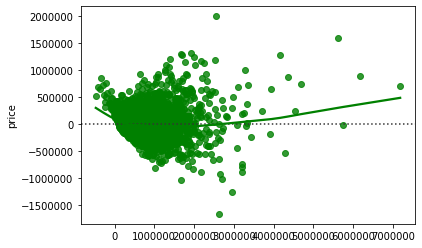

In [44]:
sns.residplot(y_train_rinter, y_train, lowess=True, color="g")

In [108]:
# Select K best features
selector_rinter = SelectKBest(f_regression, k=275)

selector_rinter.fit(X_train_inter, y_train)

C:\Users\Drago\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Drago\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Drago\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Drago\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


SelectKBest(k=275, score_func=<function f_regression at 0x000002B07602F4C8>)

In [109]:
selected_columns_rinter = X_train_inter.columns[selector_rinter.get_support()]
removed_columns_rinter = X_train_inter.columns[~selector_rinter.get_support()]

In [110]:
#instantiate a linear regression object
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest = lm_kbest.fit(X_train_inter[selected_columns_rinter], y_train)

y_train_krinter = lm_kbest.predict(X_train_inter[selected_columns_rinter])


trainKrinter_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_krinter))


print('Training Root Mean Squared Error:' , trainKrinter_rmse)

y_krinter = lm_kbest.predict(X_test_inter[selected_columns_rinter])

testKrinter_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_krinter))

print('Testing Root Mean Squared Error:' , testKrinter_rmse)


Training Root Mean Squared Error: 138517.70819275884
Testing Root Mean Squared Error: 21528189.87355333


In [111]:
ridge_inter= Ridge(alpha=0.01)

ridge_inter.fit(X_train_inter[selected_columns_rinter], y_train)

y_train_rinter= ridge_inter.predict(X_train_inter[selected_columns_rinter])
y_pred_rinter= ridge_inter.predict(X_test_inter[selected_columns_rinter])

train_rmse_rinter= np.sqrt(metrics.mean_squared_error(y_train, y_train_rinter))
test_rmse_rinter= np.sqrt(metrics.mean_squared_error(y_test, y_pred_rinter))

print('Training Root Mean Squared Error:' , train_rmse_rinter)
print('Testing Root Mean Squared Error:' , test_rmse_rinter)

Training Root Mean Squared Error: 139341.17453596048
Testing Root Mean Squared Error: 13987050.18510051


C:\Users\Drago\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.42523e-23): result may not be accurate.
  overwrite_a=True).T


In [113]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [123]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif.round(1)

,VIF Factor,features
0,28.3,bedrooms
1,31.2,bathrooms
2,58.5,sqft_living
3,3.6,sqft_lot
4,23.9,floors
...,...,...
241,140.5,grade__9
242,60.8,grade__10
243,24.2,grade__11
244,6.2,grade__12


In [133]:
vif.round(1)[vif['VIF Factor']>=5]

,VIF Factor,features
0,28.3,bedrooms
1,31.2,bathrooms
2,58.5,sqft_living
4,23.9,floors
6,45.0,sqft_above
7,31.6,sqft_living15
28,12.7,Seattle
32,14.9,year__2015
36,6.3,month__5
37,8.1,month__6


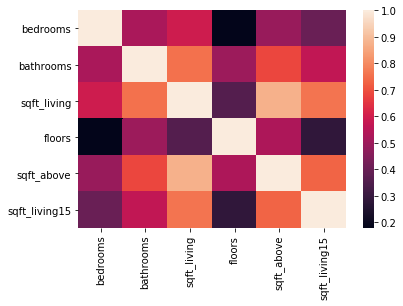

In [135]:
corr_cols=list(vif.round(1)[vif['VIF Factor']>=5]['features'].values)
sns.heatmap(features[['bedrooms','bathrooms','sqft_living','floors','sqft_above','sqft_living15']].corr())

.

.

.

.

.

.

.

.

.

.

# Ridge Scaler

In [48]:
ridge_scaler= Ridge(alpha=0.01)

ridge_scaler.fit(X_train, y_train)

y_train_ridge_scaler= ridge_scaler.predict(X_train)
y_pred_ridge_scaler= ridge_scaler.predict(X_test)

train_rmse_ridge_scaler= np.sqrt(metrics.mean_squared_error(y_train, y_train_ridge_scaler))
test_rmse_ridge_scaler= np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge_scaler))

print('Training Root Mean Squared Error:' , train_rmse_ridge_scaler)
print('Testing Root Mean Squared Error:' , test_rmse_ridge_scaler)

Training Root Mean Squared Error: 172186.4688978995
Testing Root Mean Squared Error: 173682.0087539485


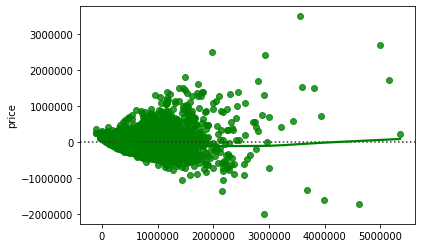

In [49]:
sns.residplot(y_train_ridge_scaler, y_train, lowess=True, color="g")

In [36]:
# price_log
ridge_scaler= Ridge(alpha=0.01)

ridge_scaler.fit(X_train, y_train)

y_train_ridge_scaler= np.exp(ridge_scaler.predict(X_train))
y_pred_ridge_scaler= np.exp(ridge_scaler.predict(X_test))

train_rmse_ridge_scaler= np.sqrt(metrics.mean_squared_error(y_train, y_train_ridge_scaler))
test_rmse_ridge_scaler= np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge_scaler))

print('Training Root Mean Squared Error:' , train_rmse_ridge_scaler)
print('Testing Root Mean Squared Error:' , test_rmse_ridge_scaler)

Training Root Mean Squared Error: 625584.2958301085
Testing Root Mean Squared Error: 627438.2022508939


In [40]:
# price_sqrt
ridge_scaler= Ridge(alpha=0.01)

ridge_scaler.fit(X_train, y_train)

y_train_ridge_scaler= (ridge_scaler.predict(X_train))**2
y_pred_ridge_scaler= (ridge_scaler.predict(X_test))**2

train_rmse_ridge_scaler= np.sqrt(metrics.mean_squared_error(y_train, y_train_ridge_scaler))
test_rmse_ridge_scaler= np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge_scaler))

print('Training Root Mean Squared Error:' , train_rmse_ridge_scaler)
print('Testing Root Mean Squared Error:' , test_rmse_ridge_scaler)

Training Root Mean Squared Error: 621087.445234778
Testing Root Mean Squared Error: 626632.682494985


In [44]:
# price_4rt
ridge_scaler= Ridge(alpha=0.01)

ridge_scaler.fit(X_train, y_train)

y_train_ridge_scaler= (ridge_scaler.predict(X_train))**4
y_pred_ridge_scaler= (ridge_scaler.predict(X_test))**4

train_rmse_ridge_scaler= np.sqrt(metrics.mean_squared_error(y_train, y_train_ridge_scaler))
test_rmse_ridge_scaler= np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge_scaler))

print('Training Root Mean Squared Error:' , train_rmse_ridge_scaler)
print('Testing Root Mean Squared Error:' , test_rmse_ridge_scaler)

Training Root Mean Squared Error: 620096.0321569052
Testing Root Mean Squared Error: 624112.1535260717


In [149]:
# interactions
ridge_scaler= Ridge(alpha=0.01)

ridge_scaler.fit(X_train_scaled, y_train)

y_train_ridge_scaler= ridge_scaler.predict(X_train_scaled)
y_pred_ridge_scaler= ridge_scaler.predict(X_test_scaled)

train_rmse_ridge_scaler= np.sqrt(metrics.mean_squared_error(y_train, y_train_ridge_scaler))
test_rmse_ridge_scaler= np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge_scaler))

print('Training Root Mean Squared Error:' , train_rmse_ridge_scaler)
print('Testing Root Mean Squared Error:' , test_rmse_ridge_scaler)

Training Root Mean Squared Error: 170499.8647702953
Testing Root Mean Squared Error: 171870.9777023283


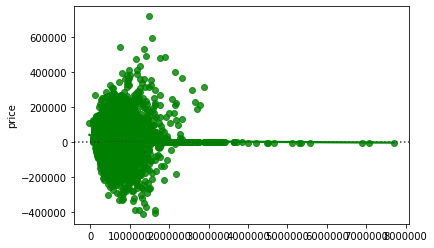

In [43]:
sns.residplot(y_train_ridge_scaler, y_train, lowess=True, color="g")